In [1]:
!pip install -q biopython

     |████████████████████████████████| 2.3MB 9.1MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -r '/content/drive/My Drive/dna_nn' .
!ls dna_nn

download.py  load.py


In [4]:
import gc

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

from dna_nn.load import encode, encoded_shape, gen_from_arrays

%load_ext autoreload
%autoreload 2

In [5]:
DATA_PATH = '/content/drive/My Drive/data/UCI/promoters.data'

data = pd.read_csv(DATA_PATH, header=None, sep=',\\W*', engine='python',
                   usecols=[0, 2])
data.columns = ['class', 'sequence']
data['sequence'] = data['sequence'].str.upper()
data['class'] = data['class'].map(lambda y: int(y == '+'))
data.head()
data.shape

(106, 2)

# features: 57 bp


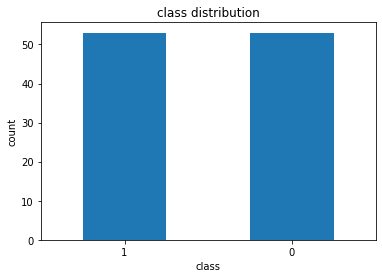

In [6]:
ax = data['class'].value_counts().plot(kind='bar')
ax.set_title('class distribution')
ax.set_xlabel('class')
ax.set_ylabel('count')
ax.tick_params(rotation=0)

print('# features:', len(data['sequence'][0]), 'bp')

# Conv2D

In [7]:
word_size = 3
region_size = 0

encode_func = encode(word_size, region_size)
x_shape = encoded_shape(data['sequence'][0], word_size, region_size)

x, y = data['sequence'].to_numpy(), data['class'].to_numpy()
x = np.array([encode_func(_) for _ in x])
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

len(x_train), len(x_test)

(79, 27)

In [8]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv2D(8, 3, activation='relu', input_shape=x_shape),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(2, activation='softmax'),
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 53, 62, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 31, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6448)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6448)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 51592     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 18        
Total params: 51,690
Trainable params: 51,690
Non-trainable params: 0
____________________________________________________

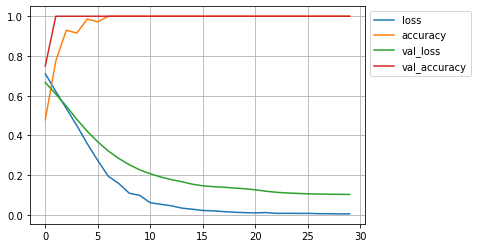

In [9]:
history = model.fit(x_train, y_train, epochs=30, validation_split=0.1, verbose=0)
ax = pd.DataFrame(history.history).plot()
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.grid()

In [11]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 1ms/step - loss: 0.1777 - accuracy: 1.0000


[0.17773978412151337, 1.0]

In [13]:
pd.DataFrame(history.history).to_csv('/content/drive/My Drive/dna-nn/UCI/promoter-conv2D.csv', index=False)
model.save('/content/drive/My Drive/dna-nn/UCI/promoter-conv2D.h5')

# Conv1D

In [14]:
encode_func = encode(word_size, region_size, expand=False)
x_shape = encoded_shape(data['sequence'][0], word_size, region_size, expand=False)

x, y = data['sequence'].to_numpy(), data['class'].to_numpy()
x = np.array([encode_func(_) for _ in x])
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

len(x_train), len(x_test)

(79, 27)

In [32]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Conv1D(32, 3, activation='relu', input_shape=x_shape),
    keras.layers.MaxPooling1D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(2, activation='softmax'),
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 53, 32)            6176      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 26, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 832)               0         
_________________________________________________________________
dropout (Dropout)            (None, 832)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                26656     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 32,898
Trainable params: 32,898
Non-trainable params: 0
____________________________________________________

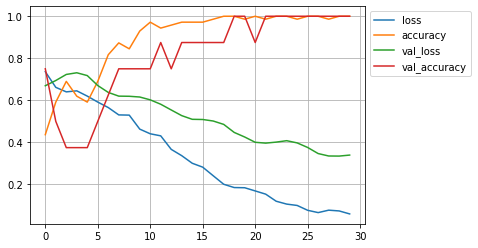

In [33]:
history = model.fit(x_train, y_train, epochs=30, validation_split=0.1, verbose=0)
ax = pd.DataFrame(history.history).plot()
ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
ax.grid()

In [35]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 2ms/step - loss: 0.3851 - accuracy: 0.8148


[0.3851318359375, 0.8148148059844971]

In [36]:
pd.DataFrame(history.history).to_csv('/content/drive/My Drive/dna-nn/UCI/promoter-conv1D.csv', index=False)
model.save('/content/drive/My Drive/dna-nn/UCI/promoter-conv1D.h5')